In [31]:
import os
import pandas as pd
import numpy as np
import nltk
import torch
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.spatial.distance import jensenshannon, cosine
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [15]:
train_all_articles = pd.read_csv('train-all-articles.csv')
train_S1_labels = pd.read_csv('train-S1-labels.csv')
train_S2_labels = pd.read_csv('train-S2-labels.csv')

# Exploratory Data Analysis

**Title:** Towards Robust Propaganda Detection: Addressing Distribution Shifts via Multi-Task Learning

**MSc Information Studies -- Data Science track**

**Name:** Alexander Hepburn

## General Summary

In [17]:
train_all_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Filename         1782 non-null   object
 1   Language         1782 non-null   object
 2   Translated_Text  1782 non-null   object
 3   Domain           1782 non-null   object
dtypes: object(4)
memory usage: 55.8+ KB


In [19]:
train_all_articles.head()

,Filename,Language,Translated_Text,Domain
0,EN_UA_104876.txt,EN,Putin honours army unit blamed for Bucha massa...,UA
1,EN_UA_011260.txt,EN,Russia has a clear plan to resolve the conflic...,UA
2,EN_UA_101067.txt,EN,"First war of TikTok era sees tragedy, humor an...",UA
3,EN_UA_300048.txt,EN,Ukraine Bombed Diesel Tanks Near A Nuclear Pla...,UA
4,EN_CC_100047.txt,EN,"Biden Has Omnibus Bill, Packed With Climate Ch...",CC


## Word Clouds

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

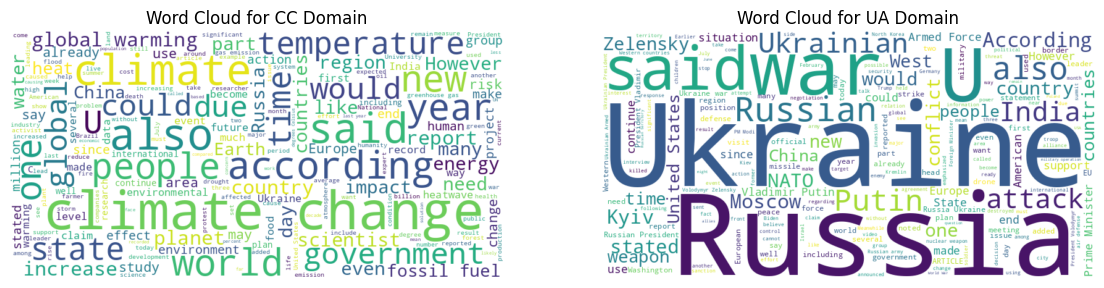

In [33]:
# Separate text by domain
cc_text = " ".join(train_all_articles[train_all_articles["Domain"] == "CC"]["Translated_Text"].dropna())
ua_text = " ".join(train_all_articles[train_all_articles["Domain"] == "UA"]["Translated_Text"].dropna())

# Define stopwords
stop_words = set(stopwords.words('english'))

# Generate word clouds
wordcloud_cc = WordCloud(stopwords=stop_words, background_color="white", width=800, height=400).generate(cc_text)
wordcloud_ua = WordCloud(stopwords=stop_words, background_color="white", width=800, height=400).generate(ua_text)

# Display the word clouds
plt.figure(figsize=(14, 6))

# CC Domain
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_cc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for CC Domain")

# UA Domain
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_ua, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for UA Domain")

plt.show()


## Distribution Shifts

# Entity Framing

# Narrative Classification

In [ ]:
# =============================
# 0. Imports and Config
# =============================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import gc
import os
from tqdm import tqdm
import sentencepiece

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Config
MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LEN = 512
BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 2e-5
MODEL_PATH = "best_model.pt"


In [ ]:
# =============================
# 1. Load and Prepare Data
# =============================
articles = pd.read_csv("train-all-articles.csv")
labels = pd.read_csv("train-S2-labels.csv")

# Merge and preprocess
df = articles.merge(labels, on="Filename")
df = df.dropna(subset=["Translated_Text", "Narrative"])
df["Narrative"] = df["Narrative"].apply(lambda x: [n.strip() for n in str(x).split(";")])

# Multi-label binarization
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["Narrative"])
num_classes = len(mlb.classes_)


In [ ]:
# =============================
# 2. Tokenization and Dataset (with Chunking)
# =============================
from transformers import DebertaV2Tokenizer

# Replace the AutoTokenizer with the correct tokenizer for the DeBERTa model
tokenizer = DebertaV2Tokenizer.from_pretrained(MODEL_NAME)

def chunk_text(text, tokenizer, max_len):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    chunks = [tokens[i:i + max_len] for i in range(0, len(tokens), max_len)]
    return chunks

class MultiLabelNarrativeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Chunking on raw text
        words = text.split()
        chunks = [" ".join(words[i:i + self.max_len]) for i in range(0, len(words), self.max_len)]

        input_ids, attention_masks = [], []
        for chunk in chunks:
            encoded = tokenizer.encode_plus(
                chunk,
                max_length=self.max_len,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
            input_ids.append(encoded["input_ids"])
            attention_masks.append(encoded["attention_mask"])

        return {
            "input_ids": torch.cat(input_ids),
            "attention_mask": torch.cat(attention_masks),
            "labels": torch.tensor(label, dtype=torch.float)
        }


In [ ]:
# =============================
# 3. Train/Val Split
# =============================
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["Translated_Text"].tolist(), y, test_size=0.2, random_state=42
)

train_dataset = MultiLabelNarrativeDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = MultiLabelNarrativeDataset(val_texts, val_labels, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # batch size 1 due to varying chunk count
val_loader = DataLoader(val_dataset, batch_size=1)


In [ ]:
# =============================
# 4. Model Definition
# =============================
class MultiLabelClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        batch_size, num_chunks, seq_len = input_ids.size()
        input_ids = input_ids.view(-1, seq_len)
        attention_mask = attention_mask.view(-1, seq_len)
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]
        pooled = self.dropout(pooled)
        pooled = pooled.view(batch_size, num_chunks, -1).mean(1)
        return self.classifier(pooled)

model = MultiLabelClassifier(num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=EPOCHS * len(train_loader))
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
# =============================
# 5. Training Loop with Early Stopping
# =============================
best_val_loss = float("inf")
early_stop_counter = 0
patience = 2

print("\n Training commences...\n")
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].squeeze(0).to(device)
        attention_mask = batch["attention_mask"].squeeze(0).to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].squeeze(0).to(device)
            attention_mask = batch["attention_mask"].squeeze(0).to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), MODEL_PATH)
        print("Best model saved.")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

In [1]:

# =============================
# 6. Evaluation
# =============================
def get_predictions_and_labels(dataloader, model, threshold=0.5):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].squeeze(0).to(device)
            attention_mask = batch["attention_mask"].squeeze(0).to(device)
            labels = batch["labels"].cpu().numpy()

            outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs >= threshold).astype(int)

            all_preds.extend(preds)
            all_labels.extend(labels)

    return np.array(all_preds), np.array(all_labels)

model.load_state_dict(torch.load(MODEL_PATH))
y_pred, y_true = get_predictions_and_labels(val_loader, model)

print("\n📊 Evaluation Metrics on Validation Set:")
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"F1 Score (Micro):  {f1_score(y_true, y_pred, average='micro'):.4f}")
print(f"F1 Score (Macro):  {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='micro'):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred, average='micro'):.4f}")

print("\n📝 Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0))



/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

🚀 Training starts...

 24%|██▍       | 368/1531 [00:53<02:47,  6.93it/s]


KeyboardInterrupt: 

In [3]:
# =============================
# 7. Clear Memory
# =============================
torch.cuda.empty_cache()
gc.collect()

435

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=49d39932-ba1f-4621-a036-ab99ade88496' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>